# Prep stuff

## Installation

In [8]:
!pip install pydendroheatmap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Paths / Data

## Packager

In [69]:
paths = []
params = []
labels = []

add_button = ToggleButton(value=False, description="Add")
done_button = ToggleButton(value=False, description="Done!")

paths_box = Text(description = "Paths")
params_box = Text(description = "Params")
stage_slider = SelectionSlider(options=[0,1,2],value=0, description="Stage")

display(paths_box, params_box, stage_slider)

display(HBox([add_button, done_button]))

while not done_button.value:
    time.sleep(1)
    if True:#add_button.value==True:
        paths.append(paths_box.value)
        params.append(params_box.value)
        labels.append(stage_slider.value)
        paths_box.value, params_box.value, stage_slider.value = "","",0
        add_button.value = False
    else: 
        pass
print("\n".join(paths))

Text(value='', description='Paths')

Text(value='', description='Params')

SelectionSlider(description='Stage', options=(0, 1, 2), value=0)

KeyboardInterrupt: ignored

In [36]:

while a!="done":
    a = input("path")
    a = input("param")
    a = input("label")

a


'a'

## m13

## Definitions

In [63]:
import numpy as np
import time
import matplotlib.pyplot as plt
import scipy, csv
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, cophenet
from scipy.spatial.distance import pdist
from sklearn.cluster import AffinityPropagation, SpectralClustering, KMeans
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from io import StringIO
import pydendroheatmap as pdh
from ipywidgets import *
from IPython.display import display
#from joblib import Parallel, delayed

np.set_printoptions(precision=4, suppress=True)
%matplotlib inline

from google.colab import drive
drive.mount('/content/drive')

class temp():
    def __init__(self, data, path, data_path=None, k=2, length=20, noise=None, res=None, tempRes=None, mode=True, paradigm="CI"):
        if data_path!=None:
            self.data = np.genfromtxt(data_path, delimiter = ",")[1:,1:]
        else:
            self.data = data
        if paradigm == "CI":
            self.paradigm = 3
        else:
            self.paradigm = 2
        if tempRes != None: #test results
            self.results = self.tempRes
        else:
            self.results = self.getResults(path, length, res, mode,  self.paradigm)
        self.frames = self.clean(self.results[:,0:2], length)
        self.length = length
        self.k = k
        self.path = path
        self.res = res
        
        self.axis_trials = np.shape(self.frames)[0]
        self.axis_freqs = self.length-self.k
        self.axis_cells = np.shape(self.data)[1]
        self.primary = np.zeros((self.axis_trials, self.axis_freqs, self.axis_cells))

        #for trial in range(np.shape(self.frames)[0]-1): #missing trial in m12 5_18_2022-----------------------
        for trial in range(np.shape(self.frames)[0]):
            mat = self.data[self.frames[trial,0]:self.frames[trial,1], 0:]
            mat = np.real(np.fft.fft(mat, axis=0))
            mat = mat[self.k:self.length]
            self.primary[trial,:,:] = mat

            #VVV deprecated primary for reference VVV
            #self.primary[trial,:] = np.ndarray.flatten(np.transpose(mat))

        self.secondary = np.reshape(self.primary, (self.axis_trials, self.axis_freqs * self.axis_cells))
        self.gamma = self.scale(np.reshape(np.mean(self.primary, axis=0),(self.axis_cells, self.axis_freqs)))

        #self.secondary = self.scale(self.secondary)
        #self.primary = np.transpose(self.secondary)
        #print(np.shape(self.secondary))
        #self.dend(self.secondary)
        #self.kmeans(self.secondary)
        
        #print(self.results[:,2])
        #print(np.shape(self.secondary))
        #print(np.shape(self.frames))
        #print(np.shape(self.results))
        

        self.acc, self.nacc = self.svcp(self.secondary, self.results[:,2])
        #self.heatMap(self.gamma, self.res, self.length)
        #plt.matshow(self.gamma)

    def scale(self, data):
        #scaler = StandardScaler()
        scaler = MinMaxScaler()
        #print(scaler.transform(data))
        return scaler.fit_transform(data)

    def svcp(self, data, exp_out):
        X_train, X_test, y_train, y_test = train_test_split(data, exp_out, test_size = 0.25, stratify = exp_out)
        classifier = SVC(random_state=0, cache_size=7000,kernel="linear")#,kernel = "linear")
        classifier.fit(X_train, y_train)

        y_pred = classifier.predict(X_test)

        noise_x = np.random.rand(np.shape(data)[0],np.shape(data)[1])
        noise_y = np.random.randint(0, high=2, size=(np.shape(data)[0]))
        noise_pred = classifier.predict(noise_x)

        #cm = confusion_matrix(y_test, y_pred)
        #print(cm)
        #print(accuracy_score(y_test, y_pred))
        #clf = make_pipeline(StandardScaler(), SVC(gamma="auto"))
        #clf.fit(data, exp_out)
        return accuracy_score(y_test, y_pred), accuracy_score(noise_y, noise_pred)

    def clean(self, frames, length):
        for trial in range(np.shape(frames)[0]):
            if frames[trial,1]-frames[trial,0]<length:
                return self.clean(frames[np.arange(len(frames))!=trial] ,length)
        return frames

    def kmeans(self, data):
        kmeans = KMeans(n_clusters=2).fit(data)
        print(kmeans.labels_)
        #for i in range(10000):
        #    print(kmeans.labels_[i])

    def plot(self, data, length):
        plt.style.use('default')
        title = "Frame " + str(self.frames[0]) + " to " + str(self.frames[1])
        plt.figure(figsize=(4,2), dpi=150)
        plt.title(title)
        for cell in range(np.shape(self.data)[1]):
            plt.plot(np.arange(0,length,1), self.data[:,cell][:])
    
    def dend(self, data):
        Z = linkage(data, "ward")
        fig = plt.figure(figsize=(10,20))
        #fig = plt.figure(figsize=(7,5))
        dn = dendrogram(Z, orientation="right")
        plt.show()

    def spec(self, data):
        clustering = SpectralClustering(n_clusters=5, assign_labels="discretize").fit(data)
        print(clustering.labels_)

    '''
    def getResults(self, path, length):
        results = []
        with open(path) as csvfile:
            reader = csv.reader(csvfile, delimiter = ",")
            for row in reader:
                if row[4]=="clean" and int(row[7])-int(row[5])>length:
                    results.append(row)
                #results.append(row)
        results = np.array(results, dtype=object)
        turn = results[1:,3]#2 for LR 3 for correct/incorrect
        new_turn = np.zeros(np.shape(turn)[0])
        for i in range(np.shape(turn)[0]):
            if turn[i] == "correct":
                new_turn[i] = 1
            else:
                new_turn[i] = 0
        new_turn = new_turn[..., None]
        results = np.transpose(np.stack((results[1:,5], results[1:,7])))#5 for start, 8 for end, 7 for turn
        results = np.concatenate((results,new_turn),axis=1).astype(int)
        return results
    '''

    def getResults(self, path, length, res, mode, paradigm):
        '''
        Columns
        0 useless
        1 INIT v FTP
        2 L v R
        3 wrong vs correct
        4 messy vs clean
        5 trial start
        6 stim start
        7 turn frame
        8 trial end
        '''
        results = []
        with open(path) as csvfile:
            reader = csv.reader(csvfile, delimiter = ",")
            reference = np.shape(self.data)[0]-2
            for row in reader:
                if row[4]=="clean" and int(row[7])-int(row[5])>length and int(row[8])<reference and (mode or row[1]=="INIT"):# and row[3]=="correct":#row[2]=="L":
                    results.append(row)
                #results.append(row)
        results = np.array(results, dtype=object)
        input = results[1:, paradigm]#2 for LR 3 for correct/incorrect
        new_input = np.zeros(np.shape(input)[0])
        for i in range(np.shape(input)[0]):
            if res=="rand":
                if np.random.randint(2)==1:
                    new_input[i] = 1
                else:
                    new_input[i] = 0
            else:
                if input[i] == "correct" or (input[i]=="L" and results[i+1,3]=="correct") or (input[i]=="R" and results[i+1,3]=="wrong"):
                    new_input[i] = 1
                else:
                    new_input[i] = 0
        new_input = new_input[..., None]
        results = np.transpose(np.stack((results[1:,5], results[1:,7])))#5 for start, 8 for end, 7 for turn
        results = np.concatenate((results,new_input),axis=1).astype(int)
        return results
    
    def heatMap(self, data, res, length):
        heatmap = pdh.DendroHeatMap(heat_map_data=data)
        
        #heatmap.colormap = heatmap.yellowBlackBlue
        #heatmap.row_labels = np.arange(np.shape(data)[0])
        temp = np.around(np.arange(1/2, (np.shape(data)[1]+1)/2, 1/2),decimals=2)
        col_labels = []
        for freq in temp:
            col_labels.append(str(freq) + "Hz")
        heatmap.col_labels = col_labels
        heatmap.title = res, length
        heatmap.show()

'''
def compute_DM(data, params, trials, sizes):
    output = np.zeros((1225+1, 4, trials))
    for trial in range(trials):
        print("starting trial", trial)
        count=0
        for upper_band in range(50):
            for lower_band in range(upper_band):
                b = temp(data, params, k=lower_band, length=upper_band)
                count = count+1
                output[count,:,trial] = output[count,:,trial] + np.array([b.acc,b.nacc,j,i])
                if(b.acc>0.9):print(b.acc,"," ,j , ",", i)
'''

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'\ndef compute_DM(data, params, trials, sizes):\n    output = np.zeros((1225+1, 4, trials))\n    for trial in range(trials):\n        print("starting trial", trial)\n        count=0\n        for upper_band in range(50):\n            for lower_band in range(upper_band):\n                b = temp(data, params, k=lower_band, length=upper_band)\n                count = count+1\n                output[count,:,trial] = output[count,:,trial] + np.array([b.acc,b.nacc,j,i])\n                if(b.acc>0.9):print(b.acc,"," ,j , ",", i)\n'

## Testing

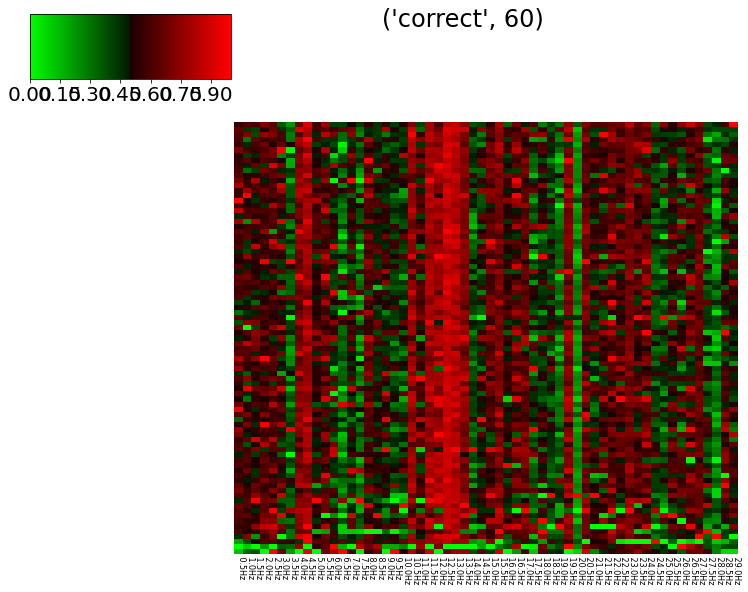

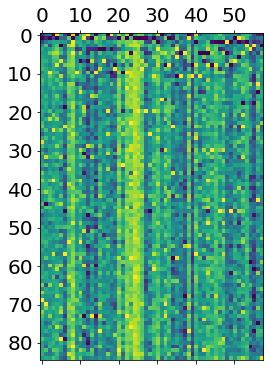

In [ ]:
a = temp(data2, params2, length=60, res="correct")
#a = temp(data2, params2, length=60)
#print(a.acc, a.nacc)

# Execution

## Main

In [10]:
paths = ["/content/drive/MyDrive/CalciumImaging_Lur のコピー/mice_datasets/m12lr/s0/04_27_2022___13_59_29/calcium_raw_04_27_2022___13_59_29.csv",
         "/content/drive/MyDrive/CalciumImaging_Lur のコピー/mice_datasets/m12lr/s0/04_28_2022___16_36_24/calcium_raw_04_28_2022___16_36_24.csv",
         #"/content/drive/MyDrive/CalciumImaging_Lur のコピー/mice_datasets/m12lr/s0/05_03_2022___17_16_41/calcium_raw_05_03_2022___17_16_41.csv",
         "/content/drive/MyDrive/CalciumImaging_Lur のコピー/mice_datasets/m12lr/s0/05_04_2022___11_06_05/calcium_raw_05_04_2022___11_06_05.csv",
         "/content/drive/MyDrive/CalciumImaging_Lur のコピー/mice_datasets/m12lr/s1/05_05_2022___16_12_21/calcium_raw_05_05_2022___16_12_21.csv",
         "/content/drive/MyDrive/CalciumImaging_Lur のコピー/mice_datasets/m12lr/s1/05_06_2022___10_48_46/calcium_raw_05_06_2022___10_48_46.csv",
         "/content/drive/MyDrive/CalciumImaging_Lur のコピー/mice_datasets/m12lr/s1/05_09_2022___17_22_31/calcium_raw_05_09_2022___17_22_31.csv",
         "/content/drive/MyDrive/CalciumImaging_Lur のコピー/mice_datasets/m12lr/s1/05_10_2022___13_54_13/calcium_raw_05_10_2022___13_54_13.csv",
         "/content/drive/MyDrive/CalciumImaging_Lur のコピー/mice_datasets/m12lr/s1/05_11_2022___12_24_04/calcium_raw_05_11_2022___12_24_04.csv",
         "/content/drive/MyDrive/CalciumImaging_Lur のコピー/mice_datasets/m12lr/s1/05_12_2022___13_28_46/calcium_raw_05_12_2022___13_28_46.csv",
         "/content/drive/MyDrive/CalciumImaging_Lur のコピー/mice_datasets/m12lr/s2/05_17_2022___16_15_20/calcium_raw_05_17_2022___16_15_20.csv",
         "/content/drive/MyDrive/CalciumImaging_Lur のコピー/mice_datasets/m12lr/s2/05_18_2022___13_28_32/calcium_raw_05_18_2022___13_28_32.csv",
         "/content/drive/MyDrive/CalciumImaging_Lur のコピー/mice_datasets/m12lr/s2/05_20_2022___15_00_32/calcium_raw_05_20_2022___15_00_32.csv",
         "/content/drive/MyDrive/CalciumImaging_Lur のコピー/mice_datasets/m12lr/s2/05_23_2022___13_56_29/calcium_raw_05_23_2022___13_56_29.csv"]

params = ["/content/drive/MyDrive/CalciumImaging_Lur のコピー/mice_datasets/m12lr/s0/04_27_2022___13_59_29/trial_parameters_04_27_2022___13_59_29.csv",
         "/content/drive/MyDrive/CalciumImaging_Lur のコピー/mice_datasets/m12lr/s0/04_28_2022___16_36_24/trial_parameters_04_28_2022___16_36_24.csv",
         #"/content/drive/MyDrive/CalciumImaging_Lur のコピー/mice_datasets/m12lr/s0/05_03_2022___17_16_41/trial_parameters_05_03_2022___17_16_41.csv",
         "/content/drive/MyDrive/CalciumImaging_Lur のコピー/mice_datasets/m12lr/s0/05_04_2022___11_06_05/trial_parameters_05_04_2022___11_06_05.csv",
         "/content/drive/MyDrive/CalciumImaging_Lur のコピー/mice_datasets/m12lr/s1/05_05_2022___16_12_21/trial_parameters_05_05_2022___16_12_21.csv",
         "/content/drive/MyDrive/CalciumImaging_Lur のコピー/mice_datasets/m12lr/s1/05_06_2022___10_48_46/trial_parameters_05_06_2022___10_48_46.csv",
         "/content/drive/MyDrive/CalciumImaging_Lur のコピー/mice_datasets/m12lr/s1/05_09_2022___17_22_31/trial_parameters_05_09_2022___17_22_31.csv",
         "/content/drive/MyDrive/CalciumImaging_Lur のコピー/mice_datasets/m12lr/s1/05_10_2022___13_54_13/trial_parameters_05_10_2022___13_54_13.csv",
         "/content/drive/MyDrive/CalciumImaging_Lur のコピー/mice_datasets/m12lr/s1/05_11_2022___12_24_04/trial_parameters_05_11_2022___12_24_04.csv",
         "/content/drive/MyDrive/CalciumImaging_Lur のコピー/mice_datasets/m12lr/s1/05_12_2022___13_28_46/trial_parameters_05_12_2022___13_28_46.csv",
         "/content/drive/MyDrive/CalciumImaging_Lur のコピー/mice_datasets/m12lr/s2/05_17_2022___16_15_20/trial_parameters_05_17_2022___16_15_20.csv",
         "/content/drive/MyDrive/CalciumImaging_Lur のコピー/mice_datasets/m12lr/s2/05_18_2022___13_28_32/trial_parameters_05_18_2022___13_28_32.csv",
         "/content/drive/MyDrive/CalciumImaging_Lur のコピー/mice_datasets/m12lr/s2/05_20_2022___15_00_32/trial_parameters_05_20_2022___15_00_32.csv",
         "/content/drive/MyDrive/CalciumImaging_Lur のコピー/mice_datasets/m12lr/s2/05_23_2022___13_56_29/trial_parameters_05_23_2022___13_56_29.csv"]

labels = [0,
          0,
          #0,
          0,
          1,
          1,
          1,
          1,
          1,
          1,
          2,
          2,
          2,
          2]

print(np.shape(paths),np.shape(params),np.shape(labels))

(13,) (13,) (13,)
['/content/drive/MyDrive/CalciumImaging_Lur のコピー/mice_datasets/m12lr/s0/04_27_2022___13_59_29/calcium_raw_04_27_2022___13_59_29.csv', '/content/drive/MyDrive/CalciumImaging_Lur のコピー/mice_datasets/m12lr/s0/04_28_2022___16_36_24/calcium_raw_04_28_2022___16_36_24.csv', '/content/drive/MyDrive/CalciumImaging_Lur のコピー/mice_datasets/m12lr/s0/05_04_2022___11_06_05/calcium_raw_05_04_2022___11_06_05.csv', '/content/drive/MyDrive/CalciumImaging_Lur のコピー/mice_datasets/m12lr/s1/05_05_2022___16_12_21/calcium_raw_05_05_2022___16_12_21.csv', '/content/drive/MyDrive/CalciumImaging_Lur のコピー/mice_datasets/m12lr/s1/05_06_2022___10_48_46/calcium_raw_05_06_2022___10_48_46.csv', '/content/drive/MyDrive/CalciumImaging_Lur のコピー/mice_datasets/m12lr/s1/05_09_2022___17_22_31/calcium_raw_05_09_2022___17_22_31.csv', '/content/drive/MyDrive/CalciumImaging_Lur のコピー/mice_datasets/m12lr/s1/05_10_2022___13_54_13/calcium_raw_05_10_2022___13_54_13.csv', '/content/drive/MyDrive/CalciumImaging_Lur のコピー/

In [3]:
paths = ["/content/drive/MyDrive/CalciumImaging_Lur のコピー/mice_datasets/m15n/s0/05_31_2022___17_07_11/calcium_raw_05_31_2022___17_07_11.csv",
         #"/content/drive/MyDrive/CalciumImaging_Lur のコピー/mice_datasets/m15n/s1/06_06_2022___11_16_46/calcium_raw_06_06_2022___11_16_46.csv",
         "/content/drive/MyDrive/CalciumImaging_Lur のコピー/mice_datasets/m15n/s1/06_07_2022___09_56_19/calcium_raw_06_07_2022___09_56_19.csv",
         "/content/drive/MyDrive/CalciumImaging_Lur のコピー/mice_datasets/m15n/s1/06_08_2022___10_33_27/calcium_raw_06_08_2022___10_33_27.csv",
         "/content/drive/MyDrive/CalciumImaging_Lur のコピー/mice_datasets/m15n/s1/06_09_2022___10_46_33/calcium_raw_06_09_2022___10_46_33.csv",
         "/content/drive/MyDrive/CalciumImaging_Lur のコピー/mice_datasets/m15n/s1/06_13_2022___12_16_24/calcium_raw_06_13_2022___12_16_24.csv",
         "/content/drive/MyDrive/CalciumImaging_Lur のコピー/mice_datasets/m15n/s1/06_14_2022___11_32_27/calcium_raw_06_14_2022___11_32_27.csv",
         "/content/drive/MyDrive/CalciumImaging_Lur のコピー/mice_datasets/m15n/s1/09_12_2022___11_59_23/calcium_raw_09_12_2022___11_59_23.csv",
         "/content/drive/MyDrive/CalciumImaging_Lur のコピー/mice_datasets/m15n/s1/09_13_2022___15_07_02/calcium_raw_09_13_2022___15_07_02.csv",
         "/content/drive/MyDrive/CalciumImaging_Lur のコピー/mice_datasets/m15n/s1/09_14_2022___13_49_35/calcium_raw_09_14_2022___13_49_35.csv",
         "/content/drive/MyDrive/CalciumImaging_Lur のコピー/mice_datasets/m15n/s2/06_15_2022___12_52_13/calcium_raw_06_15_2022___12_52_13.csv",
         "/content/drive/MyDrive/CalciumImaging_Lur のコピー/mice_datasets/m15n/s2/06_17_2022___12_11_05/calcium_raw_06_17_2022___12_11_05.csv",
         "/content/drive/MyDrive/CalciumImaging_Lur のコピー/mice_datasets/m15n/s2/09_16_2022___13_58_41/calcium_raw_09_16_2022___13_58_41.csv",
         "/content/drive/MyDrive/CalciumImaging_Lur のコピー/mice_datasets/m15n/s2/09_19_2022___11_33_25/calcium_raw_09_19_2022___11_33_25.csv"]
params = ["/content/drive/MyDrive/CalciumImaging_Lur のコピー/mice_datasets/m15n/s0/05_31_2022___17_07_11/trial_parameters_05_31_2022___17_07_11.csv",
         #"/content/drive/MyDrive/CalciumImaging_Lur のコピー/mice_datasets/m15n/s1/06_06_2022___11_16_46/trial_parameters_06_06_2022___11_16_46.csv",
         "/content/drive/MyDrive/CalciumImaging_Lur のコピー/mice_datasets/m15n/s1/06_07_2022___09_56_19/trial_parameters_06_07_2022___09_56_19.csv",
         "/content/drive/MyDrive/CalciumImaging_Lur のコピー/mice_datasets/m15n/s1/06_08_2022___10_33_27/trial_parameters_06_08_2022___10_33_27.csv",
         "/content/drive/MyDrive/CalciumImaging_Lur のコピー/mice_datasets/m15n/s1/06_09_2022___10_46_33/trial_parameters_06_09_2022___10_46_33.csv",
         "/content/drive/MyDrive/CalciumImaging_Lur のコピー/mice_datasets/m15n/s1/06_13_2022___12_16_24/trial_parameters_06_13_2022___12_16_24.csv",
         "/content/drive/MyDrive/CalciumImaging_Lur のコピー/mice_datasets/m15n/s1/06_14_2022___11_32_27/trial_parameters_06_14_2022___11_32_27.csv",
         "/content/drive/MyDrive/CalciumImaging_Lur のコピー/mice_datasets/m15n/s1/09_12_2022___11_59_23/trial_parameters_09_12_2022___11_59_23.csv",
         "/content/drive/MyDrive/CalciumImaging_Lur のコピー/mice_datasets/m15n/s1/09_13_2022___15_07_02/trial_parameters_09_13_2022___15_07_02.csv",
         "/content/drive/MyDrive/CalciumImaging_Lur のコピー/mice_datasets/m15n/s1/09_14_2022___13_49_35/trial_parameters_09_14_2022___13_49_35.csv",
         "/content/drive/MyDrive/CalciumImaging_Lur のコピー/mice_datasets/m15n/s2/06_15_2022___12_52_13/trial_parameters_06_15_2022___12_52_13.csv",
         "/content/drive/MyDrive/CalciumImaging_Lur のコピー/mice_datasets/m15n/s2/06_17_2022___12_11_05/trial_parameters_06_17_2022___12_11_05.csv",
         "/content/drive/MyDrive/CalciumImaging_Lur のコピー/mice_datasets/m15n/s2/09_16_2022___13_58_41/trial_parameters_09_16_2022___13_58_41.csv",
         "/content/drive/MyDrive/CalciumImaging_Lur のコピー/mice_datasets/m15n/s2/09_19_2022___11_33_25/trial_parameters_09_19_2022___11_33_25.csv"]
labels = [0,
          #1,
          1,
          1,
          1,
          1,
          1,
          1,
          1,
          1,
          2,
          2,
          2,
          2,
          ]

In [ ]:
#paths = []

In [ ]:
#m11
paths = ["/content/drive/MyDrive/CalciumImaging_Lur のコピー/mice_datasets/m11n/s0/05_04_2022___13_03_53/calcium_raw_05_04_2022___13_03_53.csv",
         "/content/drive/MyDrive/CalciumImaging_Lur のコピー/mice_datasets/m11n/s0/05_05_2022___16_57_34/calcium_raw_05_05_2022___16_57_34.csv",
         "/content/drive/MyDrive/CalciumImaging_Lur のコピー/mice_datasets/m11n/s1/05_06_2022___15_20_00/calcium_raw_05_06_2022___15_20_00.csv",
         "/content/drive/MyDrive/CalciumImaging_Lur のコピー/mice_datasets/m11n/s1/05_09_2022___11_58_56/calcium_raw_05_09_2022___11_58_56.csv",
         "/content/drive/MyDrive/CalciumImaging_Lur のコピー/mice_datasets/m11n/s1/05_10_2022___15_39_21/calcium_raw_05_10_2022___15_39_21.csv"]

params = ["/content/drive/MyDrive/CalciumImaging_Lur のコピー/mice_datasets/m11n/s0/05_04_2022___13_03_53/trial_parameters_05_04_2022___13_03_53.csv",
          "/content/drive/MyDrive/CalciumImaging_Lur のコピー/mice_datasets/m11n/s0/05_05_2022___16_57_34/trial_parameters_05_05_2022___16_57_34.csv",
          "/content/drive/MyDrive/CalciumImaging_Lur のコピー/mice_datasets/m11n/s1/05_06_2022___15_20_00/trial_parameters_05_06_2022___15_20_00.csv",
          "/content/drive/MyDrive/CalciumImaging_Lur のコピー/mice_datasets/m11n/s1/05_09_2022___11_58_56/trial_parameters_05_09_2022___11_58_56.csv",
          "/content/drive/MyDrive/CalciumImaging_Lur のコピー/mice_datasets/m11n/s1/05_10_2022___15_39_21/trial_parameters_05_10_2022___15_39_21.csv"]
labels = [0,0,1,1,1]

In [ ]:
#Buggy one
paths = ["/content/drive/MyDrive/CalciumImaging_Lur のコピー/mice_datasets/m15n/s1/06_06_2022___11_16_46/calcium_raw_06_06_2022___11_16_46.csv"]
params = ["/content/drive/MyDrive/CalciumImaging_Lur のコピー/mice_datasets/m15n/s1/06_06_2022___11_16_46/trial_parameters_06_06_2022___11_16_46.csv"]
labels = [1]

In [ ]:
paths = ["/content/drive/MyDrive/CalciumImaging_Lur のコピー/mice_datasets/m12lr/s2/05_23_2022___13_56_29/calcium_raw_05_23_2022___13_56_29.csv"]

params = ["/content/drive/MyDrive/CalciumImaging_Lur のコピー/mice_datasets/m12lr/s2/05_23_2022___13_56_29/trial_parameters_05_23_2022___13_56_29.csv"]

labels = [2]

In [5]:
#trials = 1
#max_freq = 13
#min_acc = 0.9
#sessions = np.shape(labels)[0]

def gen_noise():
    return np.random.rd()

def gen_super_mat(saveto, paths, params, labels, paradigm, max_freq=13, trials=100):
    axis_0 = int(0.5 * max_freq * (max_freq-1))+1 #axis_0 = 1225+1 for max_freq = 50 ref
    super_mat = np.zeros((axis_0,4,trials,np.shape(labels)[0]))
    progress_model = IntProgress(min=0, max=int(0.5 * max_freq * (max_freq-1)),description="Model 0/0")
    progress_trial = IntProgress(min=0, max=trials,description="Trial 0/" + str(trials))
    progress_session = IntProgress(min=0, max=np.shape(labels)[0], description="Session 0/"+ str(np.shape(labels)[0]))
    #print("Progress")
    display(progress_model)
    display(progress_trial)
    display(progress_session)
    '''
    print("Results")
    max_acc = IntProgress(min=0,max=100, description="Max Acc " + str(0) + "/100")
    max_acc.description = "Max Acc " + str(max_acc.value) + "/100"
    '''
    for session in range(np.shape(labels)[0]):
        session_number = str(session) + "/" + str(np.shape(labels)[0])
        if labels[session]==0:
            super_mat[:,:,:,session] = fil_s0(paths[session],params[session],session_number,progress_model,progress_trial,paradigm,max_freq,trials)
        elif labels[session]==1:
            super_mat[:,:,:,session] = fil_s1(paths[session],params[session],session_number,progress_model,progress_trial,paradigm,max_freq,trials)
        elif labels[session]==2:
            super_mat[:,:,:,session] = fil_s2(paths[session],params[session],session_number,progress_model,progress_trial,paradigm,max_freq,trials)
        else:
            print("mislabel present")
        np.save(saveto, super_mat)
        progress_session.value+=1
        progress_session.description = "Session " + str(progress_session.value) + "/" + str(np.shape(labels)[0])
    return super_mat

def fil_s0(data_path, params,session_number,progress_model, progress_trial,paradigm,max_freq,trials):
    output = np.zeros((int(0.5 * max_freq * (max_freq-1))+1,4,trials))
    progress_trial.value = 0
    data = np.genfromtxt(data_path, delimiter = ",")[1:,1:]
    for trial in range(trials):
        #print("starting trial", trial, "s0", session_number)
        count = 0
        progress_model.value=0  
        for upper_freq in range(max_freq):
            for lower_freq in range(upper_freq):
                b = temp(data, params, k=lower_freq, length=upper_freq, paradigm=paradigm, res="rand")# adjust as needed
                count+=1
                progress_model.value+=1
                progress_model.description = "Model " + str(count) + "/" +str(int(0.5*max_freq*(max_freq-1)))
                output[count,:,trial] = output[count,:,trial] + np.array([b.acc, b.nacc, lower_freq, upper_freq])
                #if (b.acc>min_acc):print(b.acc, ",", lower_freq, ",", upper_freq)
        progress_trial.value+=1
        progress_trial.description = "Trial " + str(progress_trial.value) + "/" + str(trials)
    return output

def fil_s1(data_path, params,session_number,progress_model,progress_trial,paradigm,max_freq,trials):
    output = np.zeros((int(0.5 * max_freq * (max_freq-1))+1,4,trials))
    progress_trial.value = 0
    data = np.genfromtxt(data_path, delimiter = ",")[1:,1:]
    for trial in range(trials):
        #print("starting trial", trial, "s1", session_number)
        count = 0
        progress_model.value=0
        for upper_freq in range(max_freq):
            for lower_freq in range(upper_freq):
                b = temp(data, params, k=lower_freq, length=upper_freq, paradigm=paradigm)
                count+=1
                progress_model.value+=1
                progress_model.description = "Model " + str(count) + "/" +str(int(0.5*max_freq*(max_freq-1)))
                output[count,:,trial] = output[count,:,trial] + np.array([b.acc, b.nacc, lower_freq, upper_freq])
                #if (b.acc>min_acc):print(b.acc, ",", lower_freq, ",", upper_freq)
        progress_trial.value+=1
        progress_trial.description = "Trial " + str(progress_trial.value) + "/" + str(trials)
    return output

def fil_s2(data_path, params,session_number,progress_model,progress_trial,paradigm,max_freq,trials):
    output = np.zeros((int(0.5 * max_freq * (max_freq-1))+1,4,trials))
    progress_trial.value = 0
    data = np.genfromtxt(data_path, delimiter = ",")[1:,1:]
    for trial in range(trials):
        #print("starting trial", trial, "s2", session_number)
        count = 0
        progress_model.value=0
        for upper_freq in range(max_freq):
            for lower_freq in range(upper_freq):
                b = temp(data, params, k=lower_freq, length=upper_freq, mode=False, paradigm=paradigm)
                count+=1
                progress_model.value+=1
                progress_model.description = "Model " + str(count) + "/" +str(int(0.5*max_freq*(max_freq-1)))
                output[count,:,trial] = output[count,:,trial] + np.array([b.acc, b.nacc, lower_freq, upper_freq])
                #if (b.acc>min_acc):print(b.acc, ",", lower_freq, ",", upper_freq)
        progress_trial.value+=1
        progress_trial.description = "Trial " + str(progress_trial.value) + "/" + str(trials)
    return output

In [7]:
super_mat = gen_super_mat("m15ci",paths,params,labels,paradigm="CI",max_freq=13,trials=1)

IntProgress(value=0, description='Model 0/0', max=78)

IntProgress(value=0, description='Trial 0/1', max=1)

IntProgress(value=0, description='Session 0/13', max=13)

In [ ]:
np.save("/content/drive/MyDrive/m15ci",super_mat)

## Analysis

In [17]:
session = 2
print(100*np.mean(super_mat,axis=2)[:,:,session])

[[   0.        0.        0.        0.    ]
 [  80.3929   49.1273    0.      100.    ]
 [  82.4643   50.4545    0.      200.    ]
 [  75.3571   49.5091  100.      200.    ]
 [  81.3571   50.5182    0.      300.    ]
 [  80.4286   50.0273  100.      300.    ]
 [  80.5      50.0364  200.      300.    ]
 [  82.3929   50.7091    0.      400.    ]
 [  80.6786   50.2091  100.      400.    ]
 [  82.25     50.2     200.      400.    ]
 [  79.2857   49.6182  300.      400.    ]
 [  82.1071   49.6       0.      500.    ]
 [  82.0714   49.8727  100.      500.    ]
 [  83.5357   50.6364  200.      500.    ]
 [  82.3571   49.4091  300.      500.    ]
 [  73.2857   49.5545  400.      500.    ]
 [  80.8571   49.6       0.      600.    ]
 [  85.1786   49.4455  100.      600.    ]
 [  85.8571   49.9273  200.      600.    ]
 [  84.75     50.1818  300.      600.    ]
 [  84.6786   50.5455  400.      600.    ]
 [  83.7143   48.9091  500.      600.    ]
 [  81.3929   49.9909    0.      700.    ]
 [  84.7143

## Numerical

In [8]:
def analyze(total_dataset, parameters):
    '''
    axis_0 = Predictions within a given randomization
    axis_1 = Recorded Information from a given prediction
    axis_2 = Randomization iteration
    axis_3 = Session (not accounted for in this function)
    '''

    col = 0
    output = np.zeros((np.shape(total_dataset)[0], np.shape(parameters)[0], np.shape(total_dataset)[3]))
    for parameter in parameters:
        param = getattr(np, parameter)
        #print(param(total_dataset, axis=2))
        output[:, col,:] = param(total_dataset, axis=2)[:,0]
        col += 1
    #print("output", np.shape(output))
    return output
    #return np.reshape(output, (np.shape(parameters)[0], np.shape(total_dataset)[3]))
    #return output

In [9]:
parameters = ["mean", "std", "amin", "amax"]

#print(np.shape(super_mat))
'''
for session in range(np.shape(super_mat)[3]):
    print(session, 100*np.amax(analyze(super_mat[:,:,:,session], parameters),axis=0))
'''
#print("super_mat", np.shape(super_mat))
print(100*np.transpose(np.amax(analyze(super_mat, parameters),axis=0)))

[[ 58.      20.1114  28.5714 100.    ]
 [ 64.5556  10.1243  48.1481  85.1852]
 [ 89.8929   7.4247  82.1429  96.4286]
 [ 86.5     10.956   66.6667 100.    ]
 [ 84.8     10.2294  70.     100.    ]
 [ 93.75     4.4651  93.75   100.    ]
 [ 78.1818  13.874   63.6364 100.    ]
 [ 76.5714  12.8037  64.2857  92.8571]
 [ 83.0667  10.9747  66.6667 100.    ]
 [ 62.9     15.9374  40.     100.    ]
 [ 70.65    10.5682  55.      90.    ]
 [ 57.4762  12.1166  38.0952  90.4762]
 [ 59.4167  10.1057  41.6667  83.3333]]


## Graphical